# 0.0. IMPORTS

In [11]:
import math
import inflection
import datetime

import pandas  as pd
import numpy   as np
import seaborn as sns

from IPython.core.display import HTML
from IPython.display      import Image
from matplotlib           import pyplot as plt

## 0.1. Functions

In [12]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24

#     display(HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.options.display.float_format = '{:,.4f}'.format
#     pd.set_option('display.expand_frame_repr', False)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Reading data

In [13]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DATA DESCRIPTION

In [14]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [15]:
cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
        'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# camelcase cols to snakecase
snakecase = lambda x: inflection.underscore( x )
new_cols = list( map( snakecase , cols ) )
new_cols

# renaming cols
df1.columns = new_cols

## 1.2. Data dimensions

In [16]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1]) )

Number of rows: 1017209
Number of columns: 18


## 1.3. Data types

In [17]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. NA check

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. NA fulfill

### competition_distance  

Premissa: se a coluna 'competion_distance' for NA, significa que a loja não tem nenhum competidor próximo. Dito isso, vou calcular o valor máximo dessa coluna e atribuir um valor maior que o máximo pra todas as colunas NA. Significa que todas as colunas que tiverem o valor maior, não apresentam competidores próximos.

In [19]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan( x ) else x )

### competition_open_since_ [month/year]

Premissa: se a coluna 'competition_open_since_ [month/year]' for NA, preencher com o mês e ano da coluna 'date'. 

**Não acho que isso faça sentido, já que pra uma mesma loja, um mesmo competidor abriria em várias datas diferentes.**

In [20]:
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

### promo2_since_ [week/year]

Premissa: se a coluna 'promo2_since [week/year]' for NA, preencher com a semana e ano da coluna 'date'. 

**Também não acho que isso faça sentido, já que se essa coluna for NA, significa que a loja não adota a promo2**

In [21]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

### promo_interval

In [22]:
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12:'Dez' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else
                                                                       1 if x['month_map'] in x['promo_interval'] else 0, axis=1 )

## 1.6. Rechecking dtypes

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )
df1['is_promo'] = df1['is_promo'].astype( np.int64 )

## 1.7. Descriptive statistics

In [24]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### Numerical attributes

In [25]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion metrics - std, max, min, range, skewness, kurtosis
dm1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
dm2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
dm3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
dm4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T                    
dm5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
metrics = pd.concat( [dm2, dm3, dm4, ct1, ct2, dm1, dm5, dm6] ).T
metrics.columns = [ 'min','max','range','mean','median','std','skewness','kurtosis' ]
metrics

,min,max,range,mean,median,std,skewness,kurtosis
store,1.0000,"1,115.0000","1,114.0000",558.4297,558.0000,321.9085,-0.0010,-1.2005
day_of_week,1.0000,7.0000,6.0000,3.9983,4.0000,1.9974,0.0016,-1.2469
sales,0.0000,"41,551.0000","41,551.0000","5,773.8190","5,744.0000","3,849.9243",0.6415,1.7784
customers,0.0000,"7,388.0000","7,388.0000",633.1459,609.0000,464.4115,1.5987,7.0918
open,0.0000,1.0000,1.0000,0.8301,1.0000,0.3755,-1.7580,1.0907
promo,0.0000,1.0000,1.0000,0.3815,0.0000,0.4858,0.4878,-1.7620
school_holiday,0.0000,1.0000,1.0000,0.1786,0.0000,0.3831,1.6778,0.8152
competition_distance,20.0000,"100,000.0000","99,980.0000","5,675.7124","2,330.0000","9,085.1593",4.6372,35.2875
competition_open_since_month,1.0000,12.0000,11.0000,6.7868,7.0000,3.3111,-0.0421,-1.2326
competition_open_since_year,"1,900.0000","2,015.0000",115.0000,"2,010.3248","2,012.0000",5.5156,-7.2357,124.0713


### Categorical attributes

In [26]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

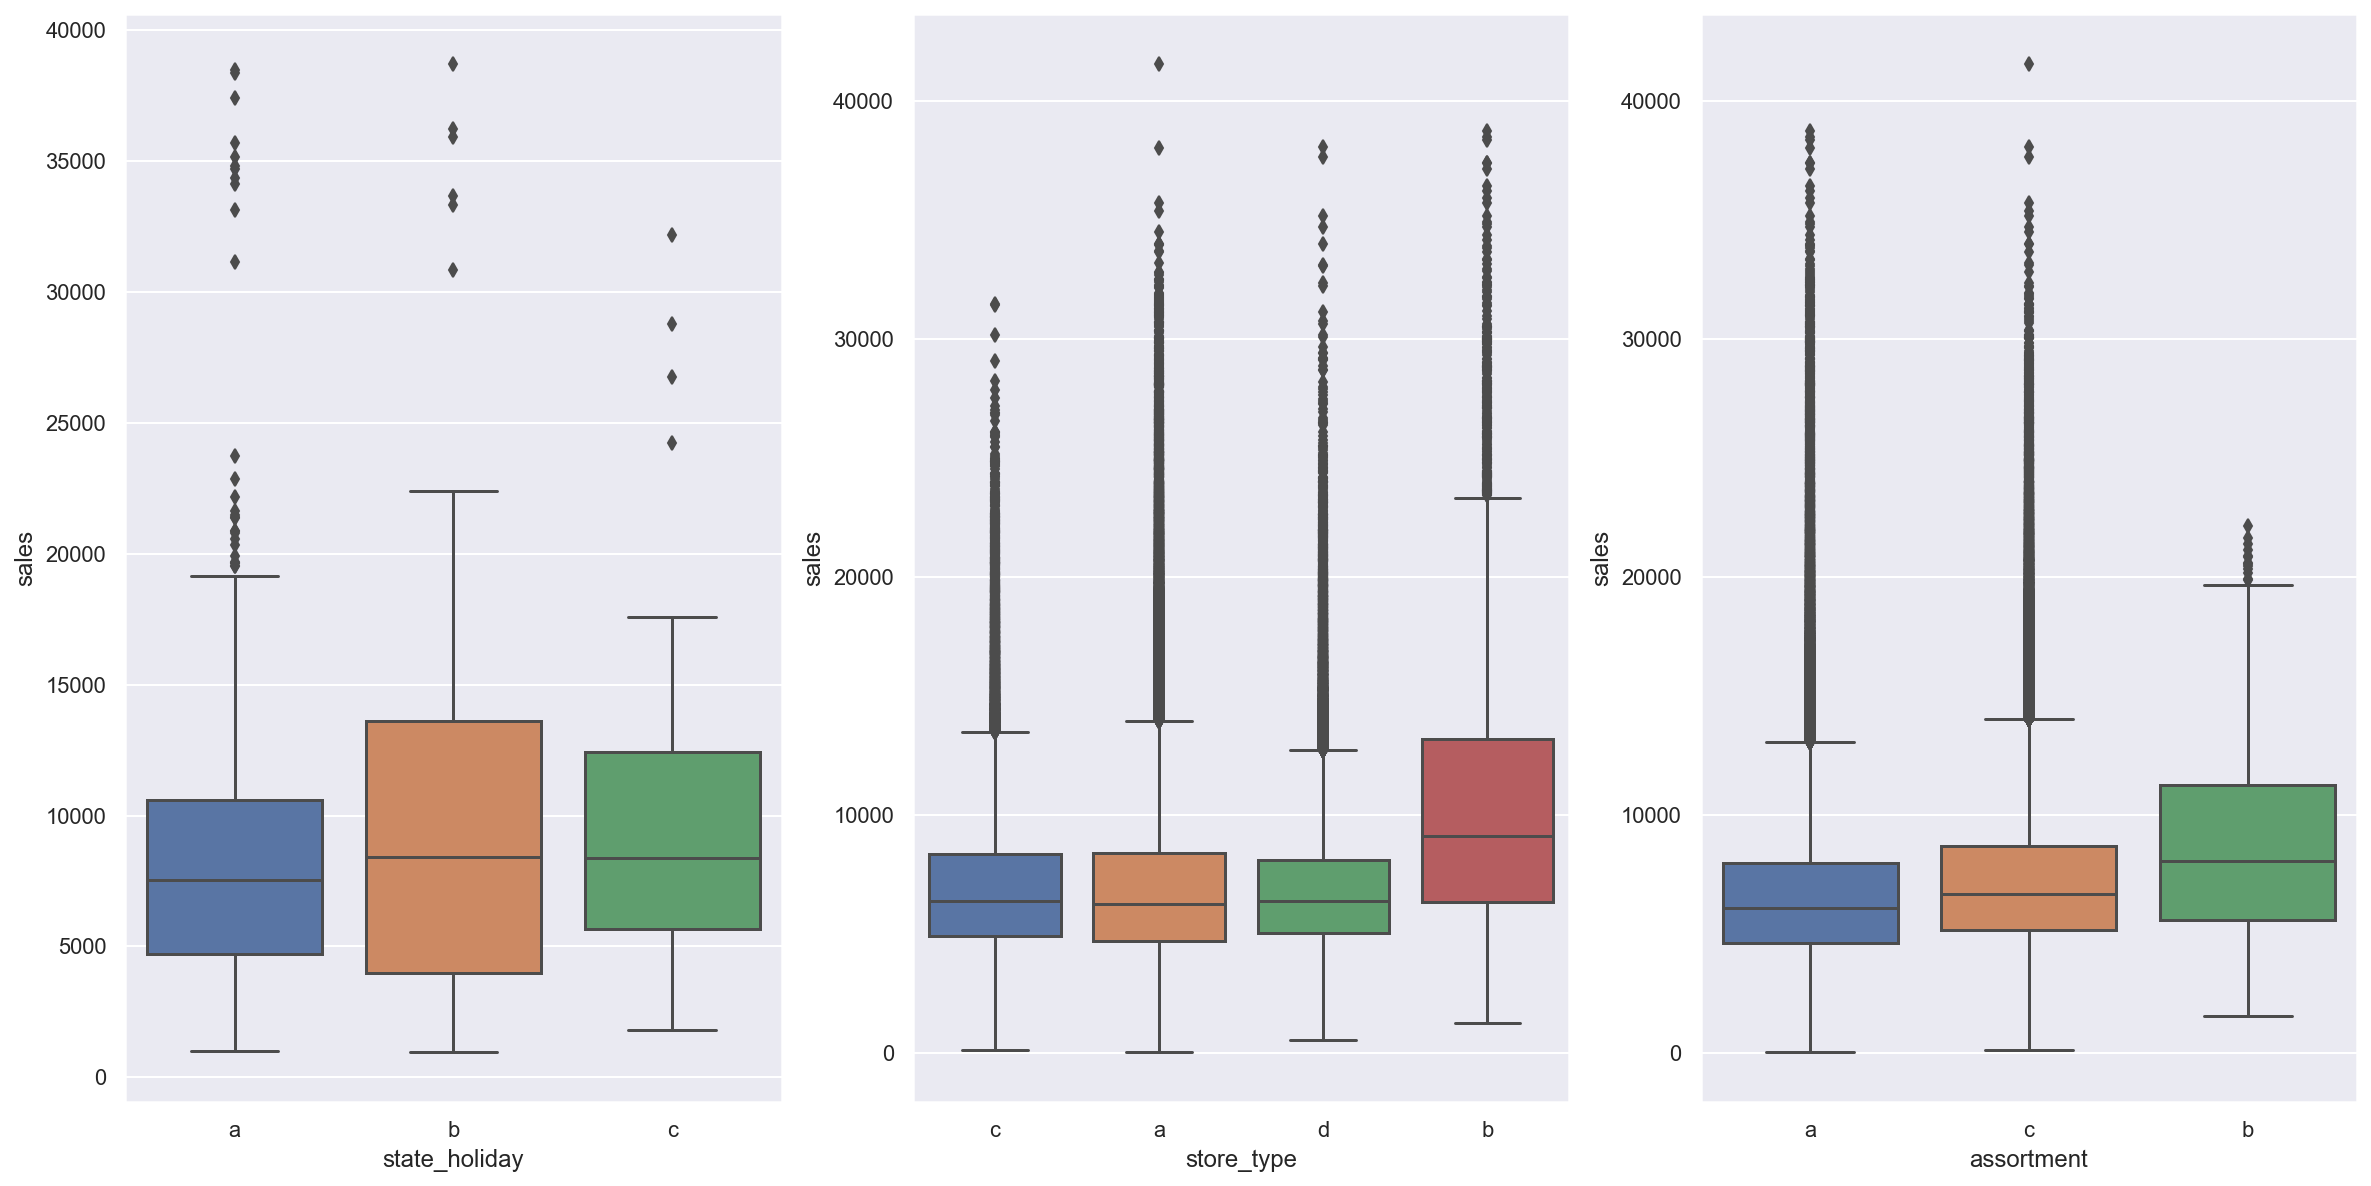

In [27]:
aux2 = df1[df1['sales'] > 0]

plt.subplot(1, 3, 1)
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot( x='state_holiday', y='sales', data=aux );

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux2 );

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux2 );

# 2.0. FEATURE ENGINEERING

## 2.1. Construção do mapa mental de hipóteses

Quais são os atributos dos agentes que afetam o fenômeno que queremos modelar?

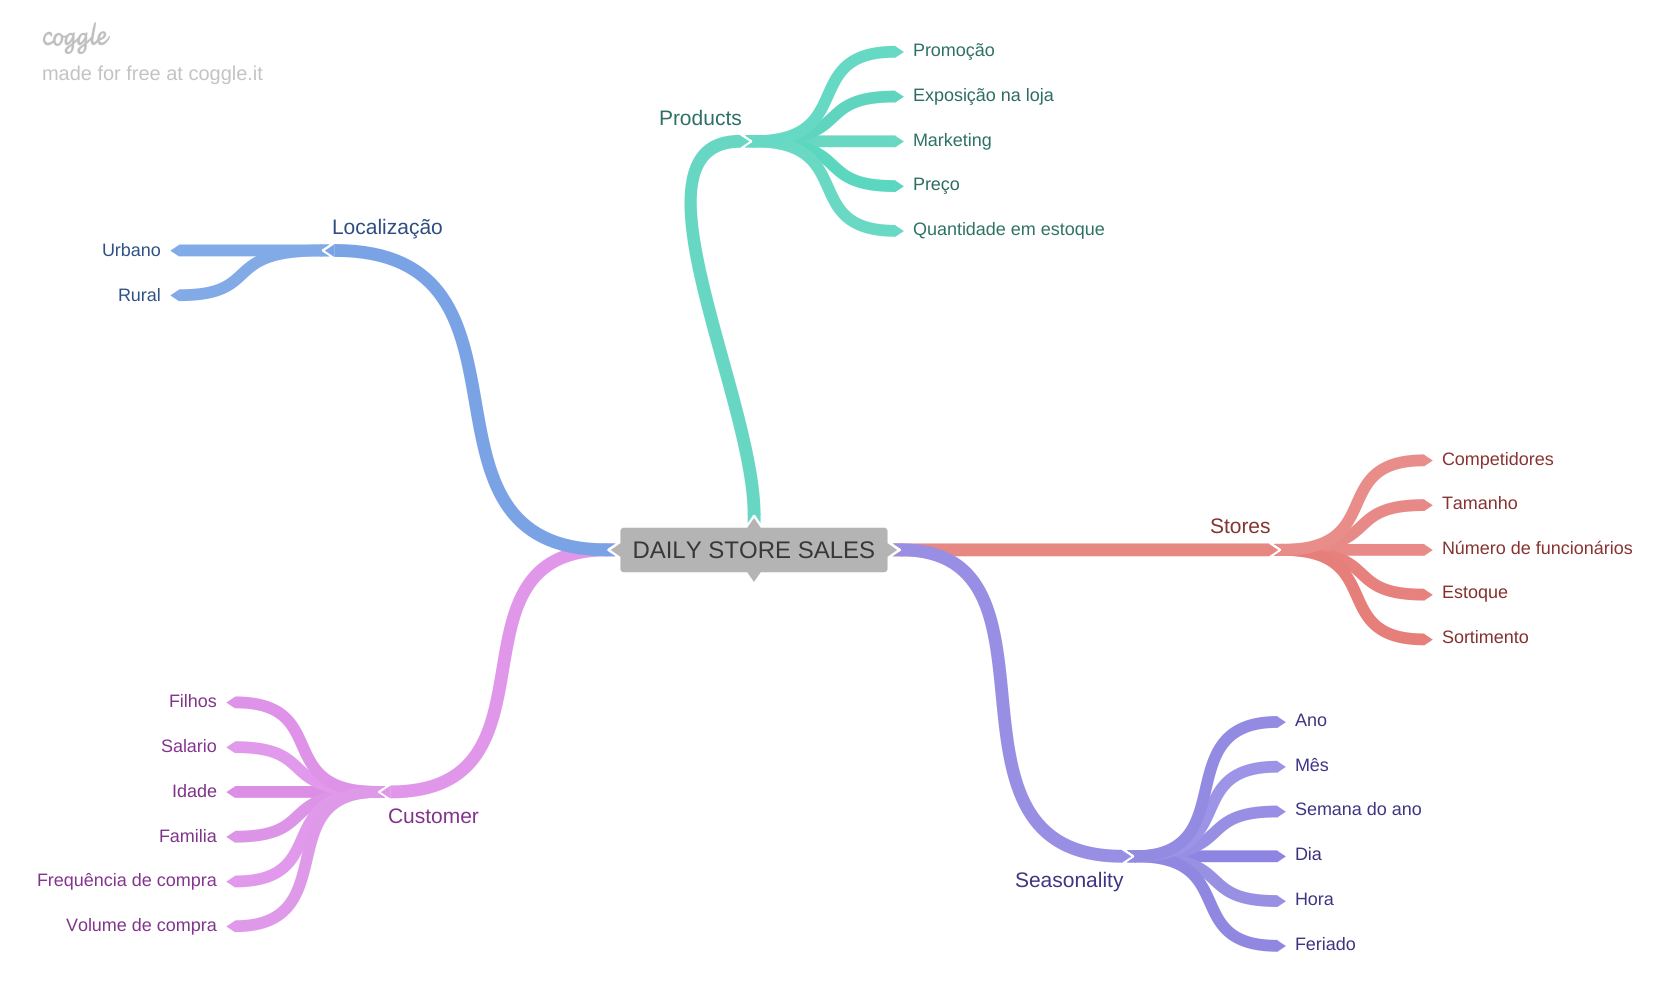

In [28]:
Image( 'img/DAILY_STORE_SALES.png' )

## 2.2. Criação de hipóteses (brainstorming)

In [29]:
df2 = df1.copy()

### 2.2.1. Hipoteses das lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses do produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.1. Hipoteses da sazonalidade

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Filtragem das hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month


# day
df2['day'] = df2['date'].dt.day


# week of year 
df2['week_of_year'] = df2['date'].dt.isocalendar().week


# year and week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'] , day=1 ), axis=1 )
df2['competition_duration_months'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )
                           
#promo2 since
df2['promo2_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1' , '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )
df2['promo2_duration_weeks'] = ( ( df2['date'] - df2['promo2_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment ( traduzir a,b,c...)
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else
                                                       'extra' if x == 'b' else 
                                                       'extended' )


#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else
                                                             'easter_holiday' if x == 'b' else 
                                                             'christmas'      if x == 'c' else
                                                             'regular_day' )

# 3.0. FILTRAGEM DE VARIÁVEIS

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_duration_months,promo2_since,promo2_duration_weeks
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,"1,270.0000",9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,"14,130.0000",12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0000,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,"29,910.0000",4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Seleção de linhas

In [36]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Seleção de colunas

In [39]:
df3 = df3.drop( ['customers','open','promo_interval','month_map'], axis=1 )